# Dog Breed Identification

This notebook builds an end-to-end multi class image classifier using Tensorflow Hub

## 1. Problem

Identifying the breed of a dog given an image of a dog.

## 2. Data

The data we're using is form kaggle's Dog Breed Identification competition.
https://www.kaggle.com/c/dog-breed-identification/overview

## 3. Evaluation

The evaluation is a file with prediction probabilities for each breed of each test image.

## 4. Features

Some information about the data :
* We're dealing with images (unstructured data) so it's probably best we use deep learning/ transfer learning.
* There are 120 breeds of dogs (This means there are 120 different classes)
* There are around 10,000+ images in training set (these images have labels)
* There are around 10,000+ images in test set (these images have no labels because we'll predict them)


### Get our Workspace Ready

* Import Tensorflow
* Import Tensorflow Hub
* Make sure to use a GPU

In [1]:
# Import necessary tools into colab
import tensorflow as tf
import tensorflow_hub as hub
print("TF Version : ",tf.__version__)
print("TF Hub Version : ", hub.__version__)

# Check for GPU availability
print('GPU', "Available (YES)" if tf.config.list_physical_devices('GPU') else "Not Available")

TF Version :  2.13.0
TF Hub Version :  0.15.0
GPU Available (YES)


## Getting our Data Ready

We'll turn our images into tensors (numerical representation)

Let's start by accessing our data and checking out labels.

In [2]:
# Checkout labels of data
import pandas as pd
labels_csv = pd.read_csv('/content/drive/MyDrive/dog-breed-identification/labels.csv')
print(labels_csv.describe())
print(labels_csv.head())


                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [3]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

<Axes: >

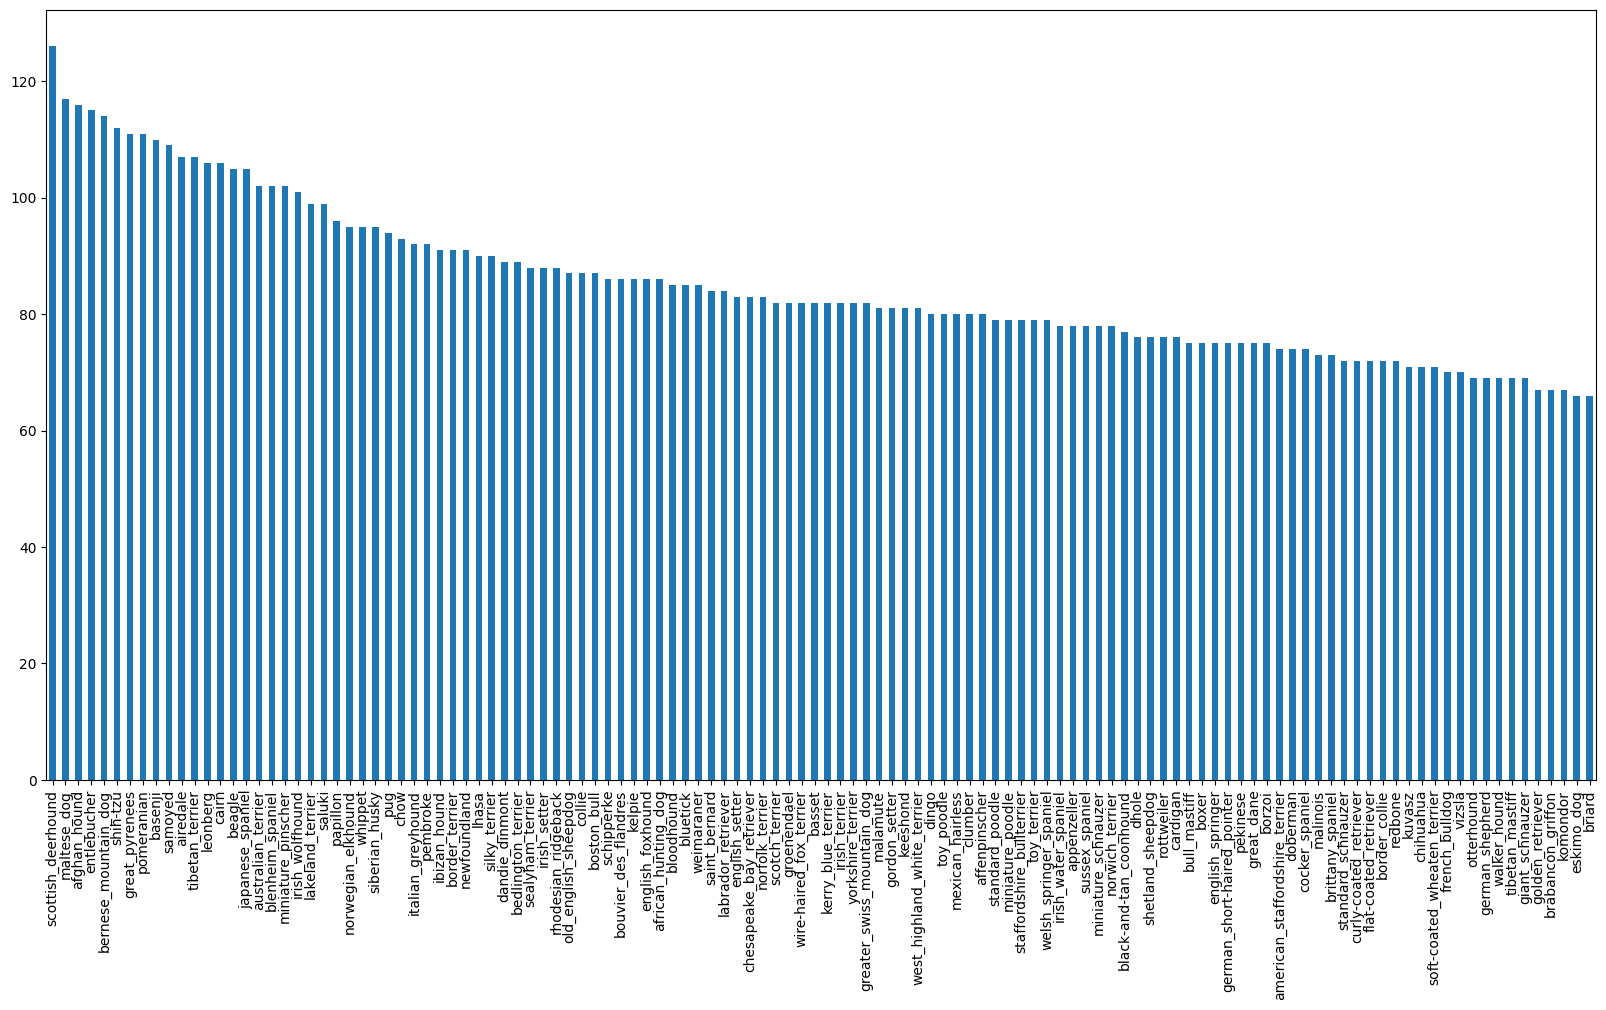

In [4]:
# How many images are there of each breed
labels_csv['breed'].value_counts().plot.bar(figsize=(20, 10))

In [ ]:
labels_csv['breed'].value_counts().median()

82.0

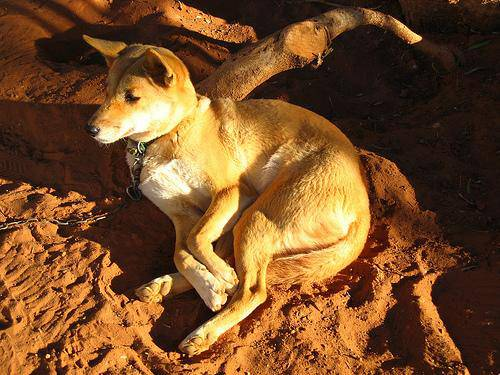

In [8]:
# Let's view an image
from IPython.display import Image
Image('/content/drive/MyDrive/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg')

### Getting images and their labels

Let's get a list of all of our image file pathnames.

In [5]:
# Create pathnames for image IDs
filenames = ["/content/drive/MyDrive/dog-breed-identification/train/"+fname + ".jpg" for fname in labels_csv['id']]

# Check filenames
filenames[:5]

['/content/drive/MyDrive/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

In [6]:
# Check whether number of filenames matches with number of actual image files
import os
if len(os.listdir('/content/drive/MyDrive/dog-breed-identification/train')) == len(filenames):
    print('Matches')
else :
    print('Not matching')
    print(len(os.listdir('/content/drive/MyDrive/dog-breed-identification/train')))
    print(len(filenames))

Matches


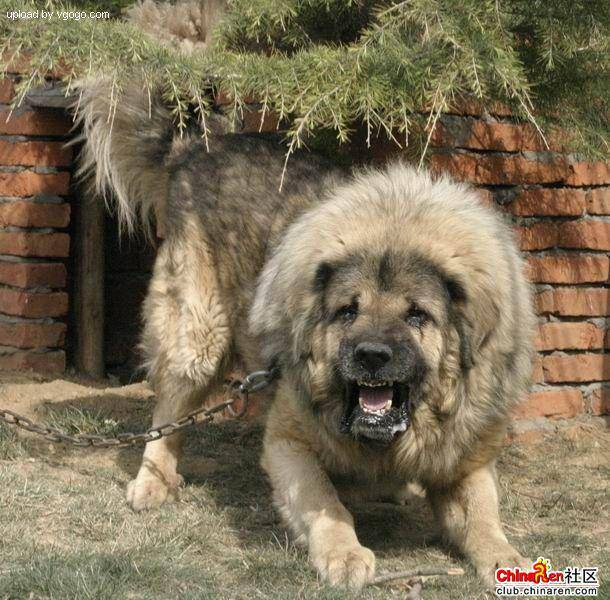

In [9]:
# One more check
Image(filenames[9000])

Let's now focus on Turning Data into Numbers


In [10]:
import numpy as np
labels = labels_csv['breed'].to_numpy()
# labels = np.array(labels) does the same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [11]:
len(labels)

10222

In [12]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
    print('Matches')
else :
    print('Doesn\'t match')

Matches


In [13]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [14]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [15]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]

In [16]:
len(boolean_labels)

10222

In [17]:
# Example : Turning boolean array into integers
print(labels[0]) # Original Label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating Validation set

Since the dataset from kaggle doesn't come with a validation set, we're going to create our own.

In [18]:
# Setup X & y variables
X = filenames
y = boolean_labels

We're going to start off experimenting with ~1000 images and increase as needed.

In [19]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:'slider', min:1000, max:10000, step:1000}

In [20]:
# Let's split our data into train and validation
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(
    X[:NUM_IMAGES],
    y[:NUM_IMAGES],
    test_size=0.2,
    random_state=42
)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [21]:
# Let's have a geez at the training data
X_train[:2], y_train[:2]

(['/content/drive/MyDrive/dog-breed-identification/train/00bee065dcec471f26394855c5c2f3de.jpg',
  '/content/drive/MyDrive/dog-breed-identification/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False,

## Preprocessing Images (Turning images into Tensors)


In [22]:
# Convert image to Numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [23]:
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

Now we've seen what an image looks like as a Tensor, let's make a function to preprocess them.


To preprocess our images into tensors, we'll write a function which does a few things :     
1. Take an image filepath as input
2. Use Tensorflow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg file) into Tensors
4. Resize the `image` to be a shape of (224, 224)
5. Return the modified `image`

In [24]:
# Define image size
IMG_SIZE = 224

def process_image(image_path, img_size = IMG_SIZE):
    """
    Takes an image file path and turns the image into a Tensor
    """
    # Read in an image file
    image = tf.io.read_file(image_path)

    # Turn the jpg image into numerical tensor with 3 color channels (Red, Green, Blue)
    image = tf.image.decode_jpeg(image, channels=3)

    # Convert the color channel values from 0-255 to 0-1 values
    image = tf.image.convert_image_dtype(image, tf.float32)

    # Resize the image to be of (224, 224)
    image = tf.image.resize(image, size=tf.constant([224, 224]))

    return image


## Turning our data into Batches

**Why turn our data into batches ?**

Let's say you're trying to process 10,000+ images in one go... they all might not fit the memory.

So that's why we do about 32 (batch size) images at a time.

You can manually adjust the batch size if needed.

In order to use Tensorflow effectively, we need our data in the form of Tensor tuples which look like this :    
`(image, label)`.

In [25]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
    """
    Takes the image path name and the associated label, preprocesses the image
    and returns a tuple of (image, label)
    """
    image = process_image(image_path)
    return (image, label)

Now we've got a way to turn out data into tuples of Tensors in the form `(image, label)`, let's make a function to turn all of our data (X & y) into batches!

In [26]:
# define a batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function tp turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    """
    Creates batches of data out of image (X) and label (y) pairs.
    Shuffles the data if it's training data but doesn't shuffle if it's validation data.
    Also shuffles test data as input (no labels)
    """
    # If the data is a test dataset, we probably don't have labels.
    if test_data:
        print('Creating test data batches...')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # Only filepaths, no labels
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        return data_batch

    # If the data is a valid dataset, we don't need to shuffle it.
    elif valid_data:
        print('Creating validation data batches...')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                                   tf.constant(y)))  # labels
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch

    else :
        print('Creating training data batches...')
        # Turn filepaths and labels into Tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                                   tf.constant(y)))  # labels
        # Shuffling pathnames and labels before mapping image processor function is faster
        data = data.shuffle(buffer_size=len(X))

        # Create (image, label) tuples (this also turns the image path into a preprocessed image)
        data = data.map(get_image_label)

        # Turn the data into data batches
        data_batch = data.batch(BATCH_SIZE)
    return data_batch

In [27]:
# Create a training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [28]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

We've got our data in batches, more specifically, they're in Tensor pairs of (images, labels) ready for use on a GPU.

But having our data in batches can be a bit hard concept to understand. Let's build a function which helps us visualize what's going on uner the hood.

### Visualizing Data Batches

In [29]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
    """
    Displays a plot of 25 images and their labels from a data batch
    """
    # Setup the figure
    plt.figure(figsize=(10, 10))
    # Loop through 25 (for displaying 25 images)
    for i in range(25):
        # Create subplots (5 rows, 5 columns)
        ax = plt.subplot(5, 5, i+1)
        # Display an image
        plt.imshow(images[i])
        # Add the image label as the image title
        plt.title(unique_breeds[labels[i].argmax()])
        # turn the gridlines off
        plt.axis("off")

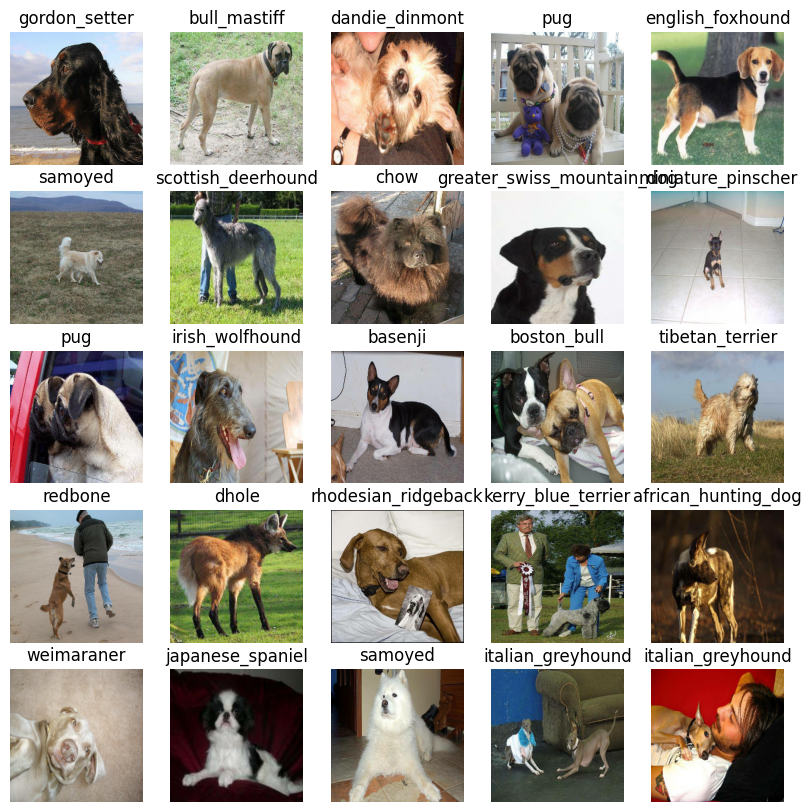

In [30]:
# Now let's visualize the data in the training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

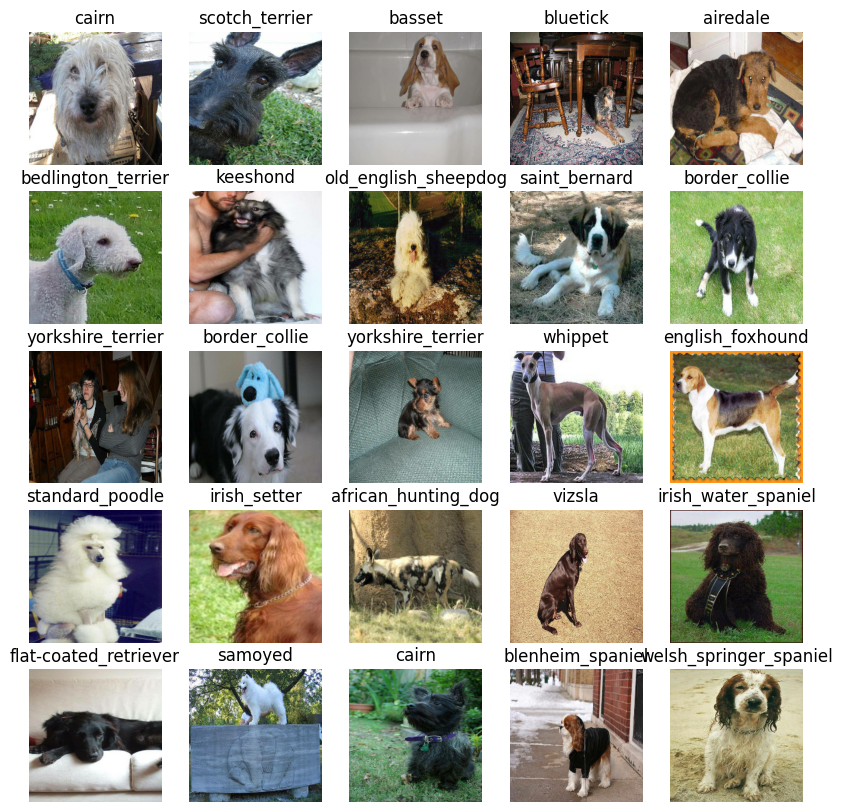

In [31]:
# Now let's visualize our validation dataset
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Creating and Training a Model

Before we build a model, there are a few things we need to define :
* the input shape (our images shape, in the form of tensors) of our model
* The output shape (image labels, in the form of tensors) of our model
* The URL of the model we want to use :
https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5

In [32]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# Setup output shape to the model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

Now we're got our inputs, outputs, model ready to go.
Let's put them together into a kera deep learning model!

Knowing this, let's create a function which :    
1. Takes the input shape, output shape and the model we've chosen as parameters
2. Define the layers in a keras model in sequential fashion (do this first, then this, then that)
3. Compiles the model (says it should be evaluated and improved)
4. Builds the model (tells the model the input shape it'll be getting)
5. Returns the model

In [33]:
# create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE,
                 output_shape=OUTPUT_SHAPE,
                 model_url=MODEL_URL):
    print('Building model with :', model_url)

    # Setup the model layers
    model = tf.keras.Sequential([
        hub.KerasLayer(model_url), # Layer 1 (input layer)
        tf.keras.layers.Dense(units=output_shape, activation='softmax') # Layer 2 (Output layer)
    ])

    # Compile the model
    model.compile(
        loss = tf.keras.losses.CategoricalCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(),
        metrics = ['accuracy']
    )

    # Build the model
    model.build(input_shape)

    return model

In [34]:
model = create_model()
model.summary()

Building model with : https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


## Creating Callbacks

Callbacks are helper functions a model can use during the training to do such things as save its progress, check its progress or stop training early if a model stops improving

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long.

### TensorBoard Callback

To setup a TensorBoard callback, we need to do 3 things :    
1. Load the TensorBoard notebook extension.
2. Create a TensorBoard callback which is able to save logs directly and pass it to our model's `fit()` function.
3. Visualize our models training logs with the `%tensorboard` magic function (we'll do this after model training)

In [35]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [36]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
    # Create a log directory for storing TensorBoard logs
    logdir = os.path.join('/content/drive/MyDrive/dog-breed-identification/logs',
                          # Make it so the logs get tracked whenever we run an experiment
                          datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
    return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback

Early stopping helps stop our model from overfitting by stopping training if a certain evaluation stops improving


In [37]:
# create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=3)

## Training a Model (on subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [38]:
NUM_EPOCHS = 100 #@param {type:'slider', min:10, max:100, step:10}


Let's create a simple function which trains a model

1. Create a model using `create_model()`
2. Setup a TensorBoard callback using `create_tensorboard_callback()`
3. Call the `fit()` function on our model passing it the training, validation, and number of epochs to train for, and the callbacks we'd like to use.
4. Return the model

In [39]:
# Build a function to train and return a trained model
def train_model():
    """
    Trains a given model and returns the trained version
    """

    # Create a model
    model = create_model()

    # Create new TensorBoard session everytime we train a model
    tensorboard = create_tensorboard_callback()

    # Fit the model to the data passing it the callbacks we created
    model.fit(x = train_data,
              epochs = NUM_EPOCHS,
              validation_data = val_data,
              validation_freq = 1,
              callbacks = [tensorboard, early_stopping])

    # Return the fitted model
    return model

In [40]:
# Fit the model to the data
model = train_model()

Building model with : https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/100
25/25 [==============================] - 272s 10s/step - loss: 4.6451 - accuracy: 0.0812 - val_loss: 3.3684 - val_accuracy: 0.2500
Epoch 2/100
25/25 [==============================] - 3s 107ms/step - loss: 1.6773 - accuracy: 0.6888 - val_loss: 2.1466 - val_accuracy: 0.4900
Epoch 3/100
25/25 [==============================] - 3s 131ms/step - loss: 0.5833 - accuracy: 0.9375 - val_loss: 1.6574 - val_accuracy: 0.5600
Epoch 4/100
25/25 [==============================] - 3s 101ms/step - loss: 0.2575 - accuracy: 0.9900 - val_loss: 1.4789 - val_accuracy: 0.6150
Epoch 5/100
25/25 [==============================] - 3s 106ms/step - loss: 0.1504 - accuracy: 0.9962 - val_loss: 1.3914 - val_accuracy: 0.6250
Epoch 6/100
25/25 [==============================] - 3s 101ms/step - loss: 0.1029 - accuracy: 1.0000 - val_loss: 1.3496 - val_accuracy: 0.6350
Epoch 7/100
25/25 [=============================

**Question** : It looks like our model is overfitting because it's performing far better on the training dataset than the validation dataset, what are some ways to prevent model overfitting in deep learning neural networks ?

**Note** : Overfitting to begin with is a good thing! It means our model is learning!

### Checking the TensorBoard Logs

The TensorBoard magic function `(%tensorboard)` will access the logs directly we created earlier and visualize its contents.

In [45]:
%tensorboard --logdir content/drive/MyDrive/dog-breed-identification/logs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-10-22 20:29:02.788087: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.

## Making and evaluating predictions using a trained model

In [46]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 1s 85ms/step


array([[3.1103897e-03, 1.9247271e-04, 5.2368949e-04, ..., 1.6193969e-04,
        1.5914551e-05, 1.0458927e-03],
       [5.5007223e-04, 5.8283150e-04, 1.4407167e-02, ..., 5.2156911e-04,
        2.2985851e-03, 6.0436410e-05],
       [9.6813574e-07, 4.6338769e-06, 3.6669362e-06, ..., 3.3311899e-05,
        7.1128134e-06, 1.7238541e-04],
       ...,
       [1.4131508e-05, 6.6684537e-05, 5.6157704e-05, ..., 1.6382521e-05,
        2.0557272e-04, 7.8988611e-05],
       [7.0640333e-03, 1.6644016e-04, 2.1088513e-04, ..., 3.7070415e-05,
        5.7634454e-05, 2.7546398e-03],
       [9.2230295e-04, 2.8439585e-05, 4.5628403e-03, ..., 5.1965923e-03,
        5.7875860e-04, 1.2344925e-04]], dtype=float32)

In [47]:
predictions.shape

(200, 120)

In [48]:
len(y_val), len(unique_breeds)

(200, 120)

In [49]:
predictions[0]

array([3.11038969e-03, 1.92472711e-04, 5.23689494e-04, 4.15589820e-05,
       1.80860690e-04, 2.53519655e-04, 1.21991578e-02, 1.59342936e-03,
       1.18816155e-04, 5.91939082e-03, 3.28362716e-04, 1.72426488e-04,
       5.85925533e-04, 1.77729726e-05, 3.46089102e-04, 4.87877522e-04,
       1.13906790e-05, 2.27826327e-01, 9.12866108e-06, 4.17281226e-05,
       5.97729464e-04, 1.43615776e-04, 1.37695724e-05, 1.46109087e-03,
       3.30943622e-05, 1.44673802e-04, 9.85746607e-02, 2.84774469e-05,
       7.60815747e-04, 4.15623101e-04, 3.80371785e-05, 2.08810926e-03,
       5.02957730e-04, 3.86141473e-05, 1.86434008e-05, 5.10462113e-02,
       3.50389455e-05, 1.41852079e-05, 1.08248087e-05, 4.91717838e-05,
       7.54813314e-04, 5.36072621e-05, 1.76060421e-05, 4.19685421e-05,
       8.16313259e-05, 7.50905338e-06, 4.09466375e-05, 1.99805843e-04,
       3.37719638e-03, 2.23457886e-04, 2.08780039e-04, 1.84520468e-05,
       1.19174350e-04, 3.81243372e-05, 1.09045235e-04, 1.06765574e-05,
      

In [50]:
# First prediction
index = 56
print(f"Max value (probability of prediction) : {np.max(predictions[index])}")
print(f"Sum : {np.sum(predictions[index])}")
print(f"Max index : {np.argmax(predictions[index])}")
print(f"predicted label : {unique_breeds[np.argmax(predictions[index])]}")

Max value (probability of prediction) : 0.9275621771812439
Sum : 0.9999999403953552
Max index : 17
predicted label : border_terrier


Having the above functionality is great but we want to be able to do it at scale.

And it would be even better if we could see the image the prediction is being made on!

**Note** : Prediction probabilities are also known as confidence levels.

In [51]:
# Turn prediction probabilities into their respective label
def get_pred_label(prediction_probabilities):
    """
    Turns an array of prediction probabilites into a label
    """
    return unique_breeds[np.argmax(prediction_probabilities)]


In [52]:
pred_label = get_pred_label(predictions[32])
pred_label

'walker_hound'

Now since our validation set is still in a batch dataset, we'll have to unbatch it to make predictions on the validation images and then compare those predictions to the validation labels (truth labels)

In [53]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
    """
    Takes a batched dataset of (image, label) Tensors and returns separate arrays
    of images and labels
    """
    images = []
    labels = []

    # Loop through unbatched data
    for image, label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(unique_breeds[np.argmax(label)])

    return images, labels

In [54]:
# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)

In [55]:
val_images[32]

array([[[0.49115023, 0.38819155, 0.30437675],
        [0.4783001 , 0.3846464 , 0.29691002],
        [0.46199232, 0.37599844, 0.29364547],
        ...,
        [0.43027928, 0.330952  , 0.20754668],
        [0.40137756, 0.31126592, 0.17400365],
        [0.36202246, 0.29087707, 0.16663706]],

       [[0.44663724, 0.3788326 , 0.2916302 ],
        [0.44854268, 0.37946433, 0.2926865 ],
        [0.44967768, 0.38048124, 0.29374278],
        ...,
        [0.3974373 , 0.31180167, 0.1675705 ],
        [0.3804492 , 0.29677877, 0.14223124],
        [0.34888124, 0.28989992, 0.14874955]],

       [[0.3803922 , 0.35365897, 0.25954133],
        [0.40298653, 0.36858672, 0.27805802],
        [0.4249814 , 0.3879202 , 0.2983744 ],
        ...,
        [0.3474472 , 0.2781736 , 0.12226877],
        [0.3375145 , 0.27717498, 0.10945936],
        [0.33175847, 0.28769246, 0.13033187]],

       ...,

       [[0.42664745, 0.5207651 , 0.27762783],
        [0.4844146 , 0.5785323 , 0.33539498],
        [0.45639375, 0

In [56]:
get_pred_label(val_labels[32])

'affenpinscher'

Now we've got ways to get :   
Prediction labels
Validation labels (truth labels)
validation images
***

Let's make some function to make these all a bit more visual
***
We'll create a function which :   

-- Takes an array of prediction probabilities, an array of truth labels and an array of images and integers.

-- Convert the prediction probabilities to a predicted label

-- Plot the predicted label, its predicted, the truth label and the target image on a single plot.


In [57]:
def plot_pred(prediction_probabilities, labels, images, n=1):
    """
    View the prediction, ground truth, and image for sample n
    """
    pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

    # Get the pred label
    pred_label = get_pred_label(pred_prob)

    # Plot the image & remove ticks
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

    # Change the color of the title depending on if prediction is right/wrong
    if pred_label == true_label:
        color='green'
    else :
        color = 'red'

    # Change plot title to be predicted, probability of prediction and truth label
    plt.title("{} {:2.0f}% {}".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label), color=color)

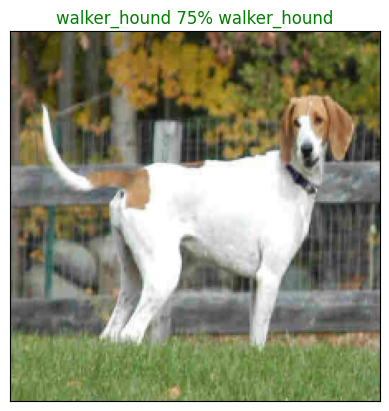

In [58]:
plot_pred(prediction_probabilities = predictions,
          labels = val_labels,
          images = val_images,
          n=32)

Now we've got one function to visualize our model top prediction.

Let's make another one to view our model's top 10 probabilities.

This function will :    
-- Take an input of prediction probabilities array and a ground truth array and an integer.

-- Find the prediction using `get_pred_label()`

-- Find the top 10

-- Plot the top 10 prediction probability values and labels, coloring the true label green.


In [59]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
    """
    Plus the top 10 highest prediction confidence along with true label for sample n
    """
    pred_prob, true_label = prediction_probabilities[n], labels[n]

    # Get the predicted label
    pred_label = get_pred_label(pred_prob)

    # Find the top 10 prediction confidence indexes
    top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]

    # Find the top 10 prediction confidence values
    top_10_pred_values = pred_prob[top_10_pred_indexes]

    # Find the top 10 prediction labels
    top_10_pred_labels = unique_breeds[top_10_pred_indexes]

    # Setup plot
    top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                       top_10_pred_values, color='grey')
    plt.xticks(np.arange(len(top_10_pred_labels)),
               labels = top_10_pred_labels,
               rotation='vertical')

    # Change color of true label
    if np.isin(true_label, top_10_pred_labels):
        top_plot[np.argmax(top_10_pred_labels == true_label)].set_color('green')
    else :
        pass


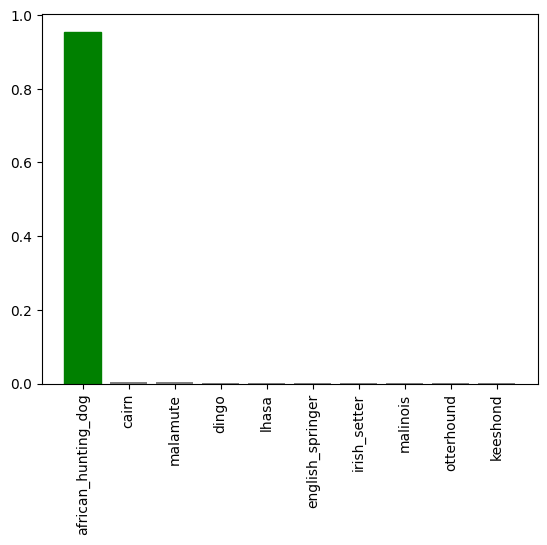

In [60]:
plot_pred_conf(prediction_probabilities = predictions,
               labels = val_labels,
               n = 17)

Now we've got some functions to help us visualize our predictions and evaluate our mdoels, let's check out a few.

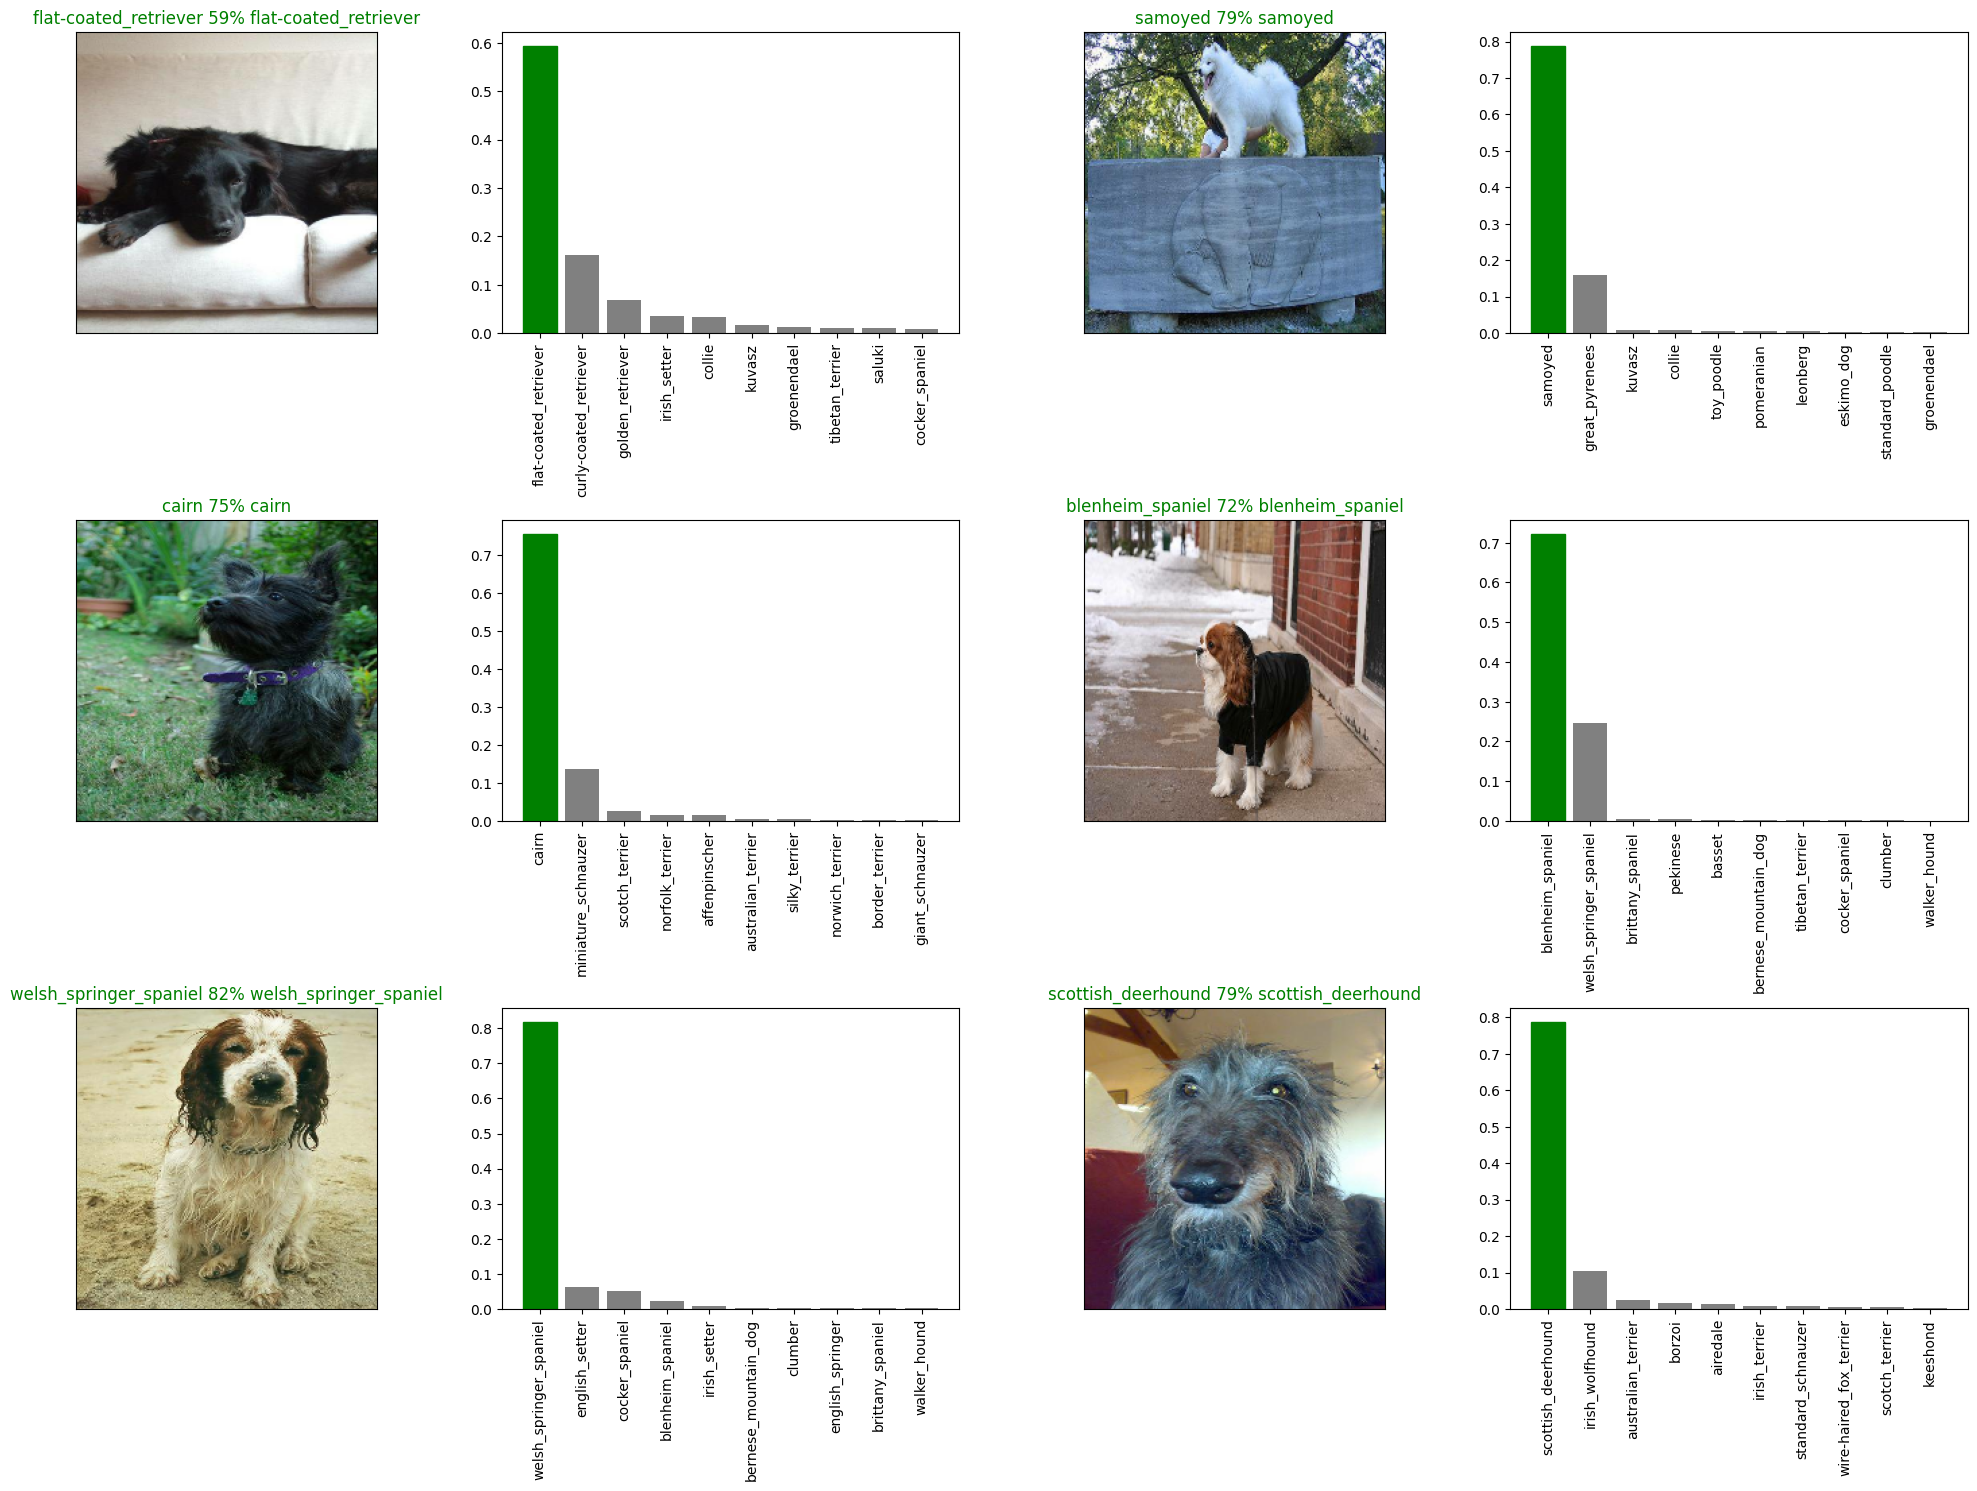

In [61]:
# Let's check out a few predictions, and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range (num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_pred(prediction_probabilities = predictions,
              labels = val_labels,
              images = val_images,
              n = i+i_multiplier)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_pred_conf(
        prediction_probabilities = predictions,
        labels = val_labels,
        n = i+i_multiplier)
plt.tight_layout()
plt.show()

## Saving and Reloading a Trained Model

In [62]:
# Create a function to save a model
def save_model(model, suffix=None):
    """
    Saves a given model in a models directory and appends a suffix (string)
    """
    # Create a model directory pathname with current time
    modeldir = os.path.join('/content/drive/MyDrive/dog-breed-identification/Models',
                            datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    model_path = modeldir + "-" + suffix + ".h5" #save format of model
    print(f"Saving model to : {model_path}...")
    model.save(model_path)
    return model_path

In [63]:
# Create a function to load a trained model
def load_model(model_path):
    """
    Loads a saved model from a specific path
    """
    print(f"Loading model from : {model_path}...")
    model = tf.keras.models.load_model(model_path,
                                      custom_objects={"KerasLayer" : hub.KerasLayer})
    return model

Now we've got functions to save and load a trained model, let's make sure they work.

In [64]:
# Save our model trained on 1000 images.
save_model(model, suffix='1000-images-mobilenetv2-Adam')

Saving model to : /content/drive/MyDrive/dog-breed-identification/Models/20231022-203112-1000-images-mobilenetv2-Adam.h5...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'/content/drive/MyDrive/dog-breed-identification/Models/20231022-203112-1000-images-mobilenetv2-Adam.h5'

In [65]:
# Load a trained model
loaded_1k_images_model = load_model('/content/drive/MyDrive/dog-breed-identification/Models/20231022-203112-1000-images-mobilenetv2-Adam.h5')

Loading model from : /content/drive/MyDrive/dog-breed-identification/Models/20231022-203112-1000-images-mobilenetv2-Adam.h5...


In [66]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 75ms/step - loss: 1.2345 - accuracy: 0.6600


[1.2344969511032104, 0.6600000262260437]

In [67]:
# Evaluate the loaded model
loaded_1k_images_model.evaluate(val_data)

7/7 [==============================] - 1s 76ms/step - loss: 1.2345 - accuracy: 0.6600


[1.2344969511032104, 0.6600000262260437]

## Training a Model on FULL DATA

In [68]:
len(X), len(y)

(10222, 10222)

In [69]:
# Create a data batch with the full data set
full_data = create_data_batches(X, y)

Creating training data batches...


In [70]:
# Create a model for full dataset
full_model = create_model()

Building model with : https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


In [71]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy',
                                                             patience=3)

**Note** : Running the cell below will take a little while (maybe upto 30 minutes for the first epoch) because the GPU we're using in the runtime has to load all of the images into memory.

In [72]:
# Fit the full model to the full data

full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks = [full_model_tensorboard, full_model_early_stopping])
%time

Epoch 1/100
320/320 [==============================] - 2243s 7s/step - loss: 1.3401 - accuracy: 0.6677
Epoch 2/100
320/320 [==============================] - 29s 90ms/step - loss: 0.4028 - accuracy: 0.8827
Epoch 3/100
320/320 [==============================] - 29s 91ms/step - loss: 0.2404 - accuracy: 0.9350
Epoch 4/100
320/320 [==============================] - 29s 89ms/step - loss: 0.1554 - accuracy: 0.9612
Epoch 5/100
320/320 [==============================] - 29s 90ms/step - loss: 0.1070 - accuracy: 0.9777
Epoch 6/100
320/320 [==============================] - 29s 89ms/step - loss: 0.0756 - accuracy: 0.9882
Epoch 7/100
320/320 [==============================] - 29s 90ms/step - loss: 0.0589 - accuracy: 0.9918
Epoch 8/100
320/320 [==============================] - 29s 89ms/step - loss: 0.0465 - accuracy: 0.9940
Epoch 9/100
320/320 [==============================] - 29s 90ms/step - loss: 0.0375 - accuracy: 0.9963
Epoch 10/100
320/320 [==============================] - 29s 89ms/step - l

In [73]:
save_model(full_model, suffix='full-image-set-mobilenetv2-Adam')

Saving model to : /content/drive/MyDrive/dog-breed-identification/Models/20231022-212106-full-image-set-mobilenetv2-Adam.h5...


'/content/drive/MyDrive/dog-breed-identification/Models/20231022-212106-full-image-set-mobilenetv2-Adam.h5'

In [74]:
# Load the full model
loaded_full_model = load_model('/content/drive/MyDrive/dog-breed-identification/Models/20231022-212106-full-image-set-mobilenetv2-Adam.h5')

Loading model from : /content/drive/MyDrive/dog-breed-identification/Models/20231022-212106-full-image-set-mobilenetv2-Adam.h5...


## Making Predictions on Test Set

Since our model has been trained on images in the form of tensors batches, to make predictions on the test data, we'll have to get it into the same format.

Luckily, we created `create_data_batches()` earlier to convert data into data batches of desired format.

To make predictions on test data, we'll :    
1. Get the test image filenames
2. Convert the filenames into test data batches
3. Make a prediction array by passing the test batches to the `predict()` method called on our model


In [75]:
# Load the test image filenames
test_path = '/content/drive/MyDrive/dog-breed-identification/test/'
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:5]

['/content/drive/MyDrive/dog-breed-identification/test/e83d7fa8fdfba0ec577f9c8df811d439.jpg',
 '/content/drive/MyDrive/dog-breed-identification/test/e71fde4ddc4c1adf9b4cf397e3904f74.jpg',
 '/content/drive/MyDrive/dog-breed-identification/test/e7b4b0e7d7d76f8dbd64920f34443b25.jpg',
 '/content/drive/MyDrive/dog-breed-identification/test/e721c3eec5951861bf3ed7f40ef8b091.jpg',
 '/content/drive/MyDrive/dog-breed-identification/test/e745d75a74a9cbdc917e7775febd88e8.jpg']

In [76]:
len(test_filenames)

10357

In [77]:
# Create test data batches
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [78]:
# Make predictions on test data using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

324/324 [==============================] - 187s 553ms/step


In [79]:
# Save predictions (NumPy arrays) to csv file (for access later)
np.savetxt('/content/drive/MyDrive/dog-breed-identification/preds_array.csv',
           test_predictions,
           delimiter=",")

In [80]:
# Load predictions (NumPy array) to csv file
test_predictions = np.loadtxt('/content/drive/MyDrive/dog-breed-identification/preds_array.csv',
                              delimiter=",")

In [81]:
test_predictions[:10]

array([[1.17229793e-09, 3.88798993e-10, 9.25431693e-12, ...,
        3.53947947e-11, 1.21595138e-11, 3.64431640e-09],
       [5.60478108e-09, 1.99087902e-09, 1.27680035e-08, ...,
        2.77014873e-08, 6.19251921e-07, 2.97162245e-07],
       [8.37633962e-09, 2.43395443e-10, 2.29722712e-08, ...,
        2.45128916e-07, 3.94032286e-05, 1.18391647e-07],
       ...,
       [1.92159128e-13, 6.30179045e-15, 2.18977423e-11, ...,
        7.42204354e-10, 9.87243880e-12, 1.40950174e-09],
       [4.01735208e-11, 8.44154115e-08, 1.37047618e-08, ...,
        1.05735990e-06, 1.09998544e-03, 6.07428730e-09],
       [4.05876843e-09, 1.02834026e-11, 2.54180479e-11, ...,
        3.62375720e-11, 7.92109607e-12, 2.25438088e-11]])

In [82]:
test_predictions.shape

(10357, 120)

## Preparing Test Dataset predictions for Kaggle

Looking at the kaggle sample submission, we find that it wants our models prediction probability outputs in a DataFrame with an ID and a column for each different dog breed.

To get the data in the format we will :    
1. Create a pandas DF with an ID column as well as a column for each dog breed.
2. Add data to the ID column by extracting the test image ID's from their filepaths
3. Add data (the prediction probabilities) to each of the dog breed columns
4. Export the DF as a csv to submit it to kaggle

In [83]:
# Create a pandas DataFrame
preds_df = pd.DataFrame(columns=['id'] + list(unique_breeds))
preds_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [84]:
# Append test image id's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df['id'] = test_ids

In [85]:
preds_df.head()

id affenpinscher afghan_hound  \
0  e83d7fa8fdfba0ec577f9c8df811d439           NaN          NaN   
1  e71fde4ddc4c1adf9b4cf397e3904f74           NaN          NaN   
2  e7b4b0e7d7d76f8dbd64920f34443b25           NaN          NaN   
3  e721c3eec5951861bf3ed7f40ef8b091           NaN          NaN   
4  e745d75a74a9cbdc917e7775febd88e8           NaN          NaN   

  african_hunting_dog airedale american_staffordshire_terrier appenzeller  \
0                 NaN      NaN                            NaN         NaN   
1                 NaN      NaN                            NaN         NaN   
2                 NaN      NaN                            NaN         NaN   
3                 NaN      NaN                            NaN         NaN   
4                 NaN      NaN                            NaN         NaN   

  australian_terrier basenji basset  ... toy_poodle toy_terrier vizsla  \
0                NaN     NaN    NaN  ...        NaN         NaN    NaN   
1                NaN     NaN    NaN  ...        NaN         NaN    NaN   
2                NaN     NaN    NaN  ...        NaN         NaN    NaN   
3                NaN     NaN    NaN  ...        NaN         NaN    NaN   
4                NaN     NaN    NaN  ...        NaN         NaN    NaN   

  walker_hound weimaraner welsh_springer_spaniel west_highland_white_terrier  \
0          NaN        NaN                    NaN                         NaN   
1          NaN        NaN                    NaN                         NaN   
2          NaN        NaN                    NaN                         NaN   
3          NaN        NaN                    NaN                         NaN   
4          NaN        NaN                    NaN                         NaN   

  whippet wire-haired_fox_terrier yorkshire_terrier  
0     NaN                     NaN               NaN  
1     NaN                     NaN               NaN  
2     NaN                     NaN               NaN  
3     NaN                     NaN               NaN  
4     NaN                     NaN               NaN  

[5 rows x 121 columns]

In [86]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

id  affenpinscher  afghan_hound  \
0  e83d7fa8fdfba0ec577f9c8df811d439   1.172298e-09  3.887990e-10   
1  e71fde4ddc4c1adf9b4cf397e3904f74   5.604781e-09  1.990879e-09   
2  e7b4b0e7d7d76f8dbd64920f34443b25   8.376340e-09  2.433954e-10   
3  e721c3eec5951861bf3ed7f40ef8b091   5.411678e-08  3.696911e-06   
4  e745d75a74a9cbdc917e7775febd88e8   1.043632e-12  5.739163e-13   

   african_hunting_dog      airedale  american_staffordshire_terrier  \
0         9.254317e-12  7.904421e-10                    9.181553e-11   
1         1.276800e-08  1.117377e-04                    1.014246e-08   
2         2.297227e-08  1.204484e-07                    1.809181e-04   
3         1.208230e-11  3.332660e-11                    5.002872e-09   
4         7.423399e-14  3.503696e-11                    1.307095e-07   

    appenzeller  australian_terrier       basenji        basset  ...  \
0  1.448441e-11        7.642844e-12  1.405026e-12  1.666047e-10  ...   
1  7.415915e-09        3.405300e-01  1.567268e-09  2.696671e-09  ...   
2  3.545298e-09        6.871815e-09  3.317234e-10  8.524557e-07  ...   
3  7.978568e-10        7.747824e-11  3.162633e-10  6.947250e-11  ...   
4  6.918984e-07        3.643857e-08  1.115370e-07  3.866882e-09  ...   

     toy_poodle   toy_terrier        vizsla  walker_hound    weimaraner  \
0  6.428688e-10  2.619787e-12  3.243483e-08  2.183570e-10  1.912148e-10   
1  5.553628e-09  7.155626e-07  6.684516e-06  1.754250e-08  3.827586e-09   
2  2.724737e-09  1.433775e-08  5.032901e-01  2.868385e-03  7.737749e-02   
3  1.000627e-07  3.769375e-11  4.889160e-10  9.150432e-08  4.752765e-07   
4  1.038211e-07  3.719262e-09  3.619114e-05  1.634543e-06  1.684469e-10   

   welsh_springer_spaniel  west_highland_white_terrier       whippet  \
0            6.263466e-09                 4.962994e-12  3.539479e-11   
1            6.434212e-10                 2.920411e-07  2.770149e-08   
2            1.091661e-09                 1.495780e-09  2.451289e-07   
3            3.827443e-10                 1.095950e-09  7.199976e-12   
4            1.347841e-10                 1.522231e-12  3.446207e-11   

   wire-haired_fox_terrier  yorkshire_terrier  
0             1.215951e-11       3.644316e-09  
1             6.192519e-07       2.971622e-07  
2             3.940323e-05       1.183916e-07  
3             1.411124e-10       3.728581e-11  
4             7.218298e-12       6.005664e-12  

[5 rows x 121 columns]

In [87]:
# Save our predictions dataframe to csv for submission to Kaggle
preds_df.to_csv('/content/drive/MyDrive/dog-breed-identification/submission_1.csv',
                index=False)

## Making predictions on custom images

To make predictions on custom images, we'll
1. Get filepaths of our own images.
2. Turn the filepaths into data batches using `create_data_batches()`
3. Pass the custom image data batch to our model's `predict()` method.
4. Convert the prediction output probabilities to predictions labels.
5. Compare the predicted labels to the custom images.

In [88]:
# Get custom image filepaths.
custom_path = '/content/drive/MyDrive/dog-breed-identification/myDogFolder/'
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [89]:
custom_image_paths

['/content/drive/MyDrive/dog-breed-identification/myDogFolder/pug-dog-isolated-white-background.jpg',
 '/content/drive/MyDrive/dog-breed-identification/myDogFolder/long-haired-brown-dog-with-tongue-out.jpg',
 '/content/drive/MyDrive/dog-breed-identification/myDogFolder/11-dog-png-image.png',
 '/content/drive/MyDrive/dog-breed-identification/myDogFolder/7-dog-png-image_400x400.png',
 '/content/drive/MyDrive/dog-breed-identification/myDogFolder/5-dog-png-image.png']

In [90]:
# Turn custom images into batch datasets
custom_data = create_data_batches(custom_image_paths, test_data=True)

Creating test data batches...


In [91]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

1/1 [==============================] - 2s 2s/step


In [92]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['pug',
 'miniature_poodle',
 'beagle',
 'bernese_mountain_dog',
 'labrador_retriever']

In [93]:
custom_images = []

# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
    custom_images.append(image)

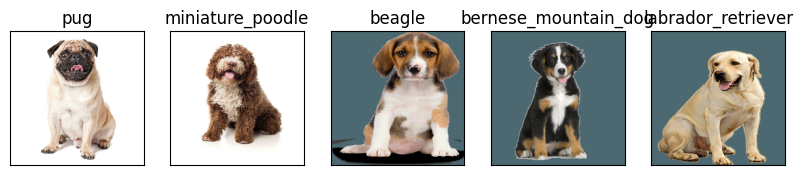

In [94]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
    plt.subplot(1, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(custom_pred_labels[i])
    plt.imshow(image)

This model now looks good enough !!!!!!!!